# VGG16 Transfer Learning 구현과 CNN모델과 성능 비교

- Tranfer Learning은 사전 학습된 모델을 활용하는 방법

- 사전 학습된 모델은 방대한 데이터에 대하여 이미 학습된 모델이기 떄문에 적은 학습 cost로 좋은 성능을 이끌어 낼 수 있음

- 사전 학습된 VGG-16 모델을 활용하는 방법에 대하여 알아보고, 일반 CNN 모델과의 성능 비교를 해보기



# 필요한 라이브러리 로딩

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16

from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# 하이퍼파라미터 정의

In [3]:
BATCH_SIZE = 64
EPOCHS = 20

In [4]:
dataset_name = 'cats_vs_dogs'
(train_dataset, validation_dataset), info = tfds.load(name=dataset_name, split=('train[:80%]', 'train[-20%:]'), with_info=True)

In [5]:
len(list(train_dataset)), len(list(validation_dataset))

(18610, 4652)

# 이미지에 대한 Normalize 진행
Training Set와 Validation Set을 만들고 BATCH_SIZE에 따라 mini batch 만듬

In [11]:
def normalize(images):
    # 0~1 사이의 값으로 Normalize 합니다.
    img, lbl = tf.cast(images['image'], tf.float32) / 255.0, images['label']
    # 300 X 300 사이즈로 resize 합니다.
    img = tf.image.resize(img, size=(300, 300))
    return img, lbl

In [12]:
train_data = train_dataset.map(normalize).batch(BATCH_SIZE).repeat().prefetch(1)
valid_data = validation_dataset.map(normalize).batch(BATCH_SIZE).repeat().prefetch(1)

steps_per_epoch과 validation_steps를 정의하여 train 함

In [13]:
steps_per_epoch= int(len(list(train_dataset)) * 0.8) // BATCH_SIZE + 1
validation_steps= int(len(list(validation_dataset)) * 0.2) // BATCH_SIZE + 1

# Convolution Neural Network

In [14]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Flatten(), 
    Dense(512, activation='relu'), 
    Dense(32, activation='relu'), 
    Dense(1, 'sigmoid')
])

In [15]:
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
cnn_history = model_cnn.fit(train_data, 
                            validation_data=(valid_data),
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=validation_steps,
                            epochs=20, 
                           )

Epoch 1/20
233/233 [==============================] - 42s 151ms/step - loss: 0.6673 - accuracy: 0.5844 - val_loss: 0.6122 - val_accuracy: 0.6948
Epoch 2/20
233/233 [==============================] - 36s 156ms/step - loss: 0.5515 - accuracy: 0.7221 - val_loss: 0.5072 - val_accuracy: 0.7542
Epoch 3/20
233/233 [==============================] - 34s 147ms/step - loss: 0.4658 - accuracy: 0.7812 - val_loss: 0.4689 - val_accuracy: 0.7781
Epoch 4/20
233/233 [==============================] - 35s 148ms/step - loss: 0.3990 - accuracy: 0.8171 - val_loss: 0.4222 - val_accuracy: 0.8052
Epoch 5/20
233/233 [==============================] - 35s 149ms/step - loss: 0.3451 - accuracy: 0.8457 - val_loss: 0.3896 - val_accuracy: 0.8208
Epoch 6/20
233/233 [==============================] - 35s 148ms/step - loss: 0.2959 - accuracy: 0.8701 - val_loss: 0.4734 - val_accuracy: 0.7979
Epoch 7/20
233/233 [==============================] - 35s 151ms/step - loss: 0.2581 - accuracy: 0.8915 - val_loss: 0.4091 - val_ac

# Transfer Learning (VGG 16) model 만들기

VGG-16은 ImageNet 데이터베이스의 1백만 개가 넘는 영상에 대해 훈련된 컨벌루션 신경망입니다. 이 네트워크에는 16개의 계층이 있으며, 영상을 키보드, 마우스, 연필, 각종 동물 등 1,000가지 사물 범주로 분류할 수 있습니다. 그 결과 이 네트워크는 다양한 영상을 대표하는 다양한 특징을 학습했습니다.

VGG-16모델을 활용하여 Transfer Learning 을 진행

<img src='https://s3.ap-south-1.amazonaws.com/techleer/309.jpg'>

In [19]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

In [20]:
transfer_model.trainable=False

In [22]:
model_tr = Sequential([
    transfer_model, 
    Flatten(), 
    Dense(64, activation='relu'), 
    Dense(1, 'sigmoid')
])

In [23]:
model_tr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
transfer_history = model_tr.fit(train_data, 
                             validation_data=(valid_data),
                             steps_per_epoch=steps_per_epoch,
                             validation_steps=validation_steps,
                             epochs=20, 
                            )

Epoch 1/20
233/233 [==============================] - 86s 343ms/step - loss: 0.3644 - accuracy: 0.8809 - val_loss: 0.1797 - val_accuracy: 0.9323
Epoch 2/20
233/233 [==============================] - 85s 366ms/step - loss: 0.1548 - accuracy: 0.9402 - val_loss: 0.1365 - val_accuracy: 0.9490
Epoch 3/20
233/233 [==============================] - 82s 351ms/step - loss: 0.1207 - accuracy: 0.9559 - val_loss: 0.1290 - val_accuracy: 0.9552
Epoch 4/20
233/233 [==============================] - 81s 346ms/step - loss: 0.0966 - accuracy: 0.9659 - val_loss: 0.1326 - val_accuracy: 0.9427
Epoch 5/20
233/233 [==============================] - 81s 346ms/step - loss: 0.0773 - accuracy: 0.9737 - val_loss: 0.1366 - val_accuracy: 0.9375
Epoch 6/20
233/233 [==============================] - 81s 347ms/step - loss: 0.0657 - accuracy: 0.9781 - val_loss: 0.1212 - val_accuracy: 0.9500
Epoch 7/20
233/233 [==============================] - 81s 346ms/step - loss: 0.0586 - accuracy: 0.9801 - val_loss: 0.1324 - val_ac

# 성능 Visualization
Losses 와 Accuracy를 보면, Transfer Learning 모델이 훨씬 초기 수렴이 빠를 뿐더러, 최종 성능도 accuracy 기준 약 10% 가량 우수하다는 것을 확인할 수 있음

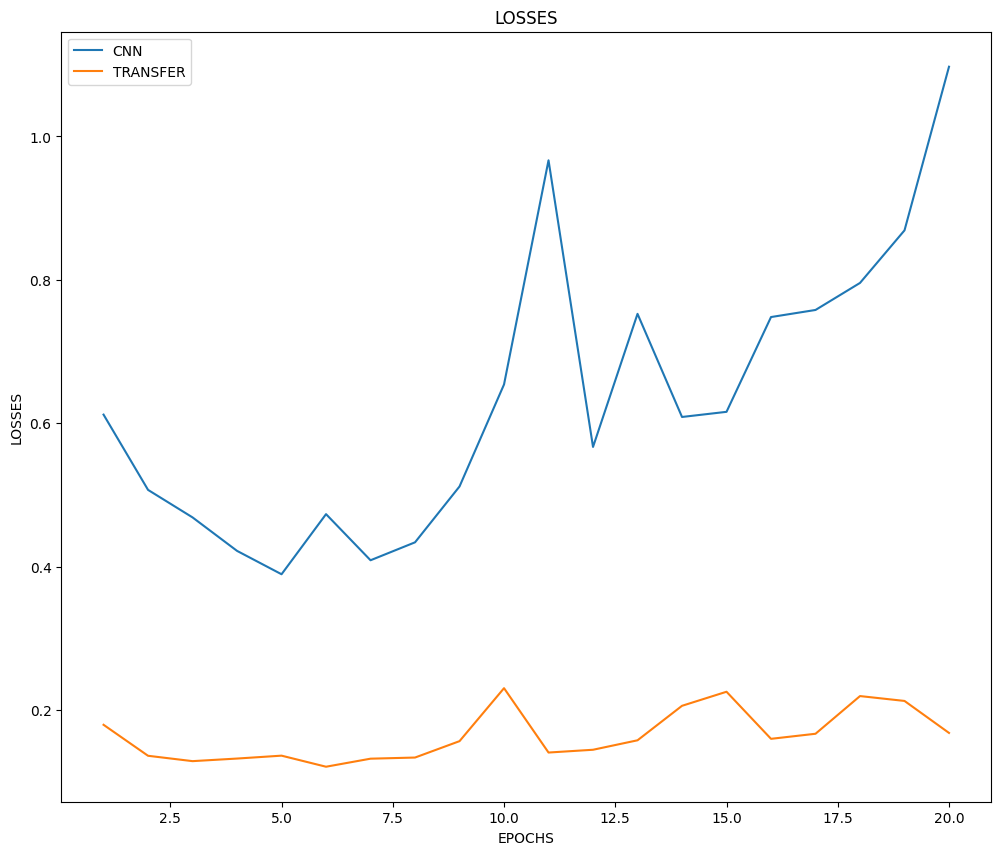

In [25]:
plt.figure(figsize=(12, 10))
plt.plot(np.arange(1, EPOCHS+1), cnn_history.history['val_loss'], label='CNN')
plt.plot(np.arange(1, EPOCHS+1), transfer_history.history['val_loss'], label='TRANSFER')
plt.xlabel('EPOCHS')
plt.ylabel('LOSSES')
plt.title('LOSSES')
plt.legend()
plt.show()

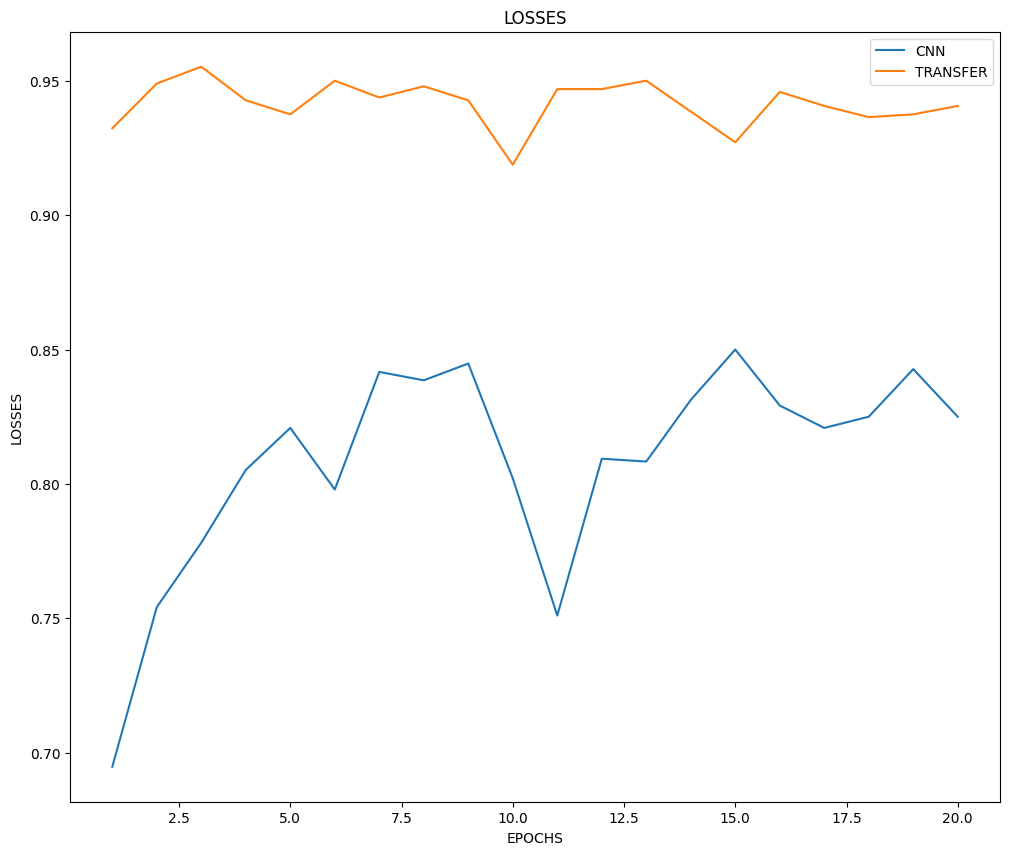

In [26]:
plt.figure(figsize=(12, 10))
plt.plot(np.arange(1, EPOCHS+1), cnn_history.history['val_accuracy'], label='CNN')
plt.plot(np.arange(1, EPOCHS+1), transfer_history.history['val_accuracy'], label='TRANSFER')
plt.xlabel('EPOCHS')
plt.ylabel('LOSSES')
plt.title('LOSSES')
plt.legend()
plt.show()